This notebook template is designed for testing the performance of Rotatron environments and different solving agents of different scales.

In [31]:
# =============================================================================
# Work on local biobuild in GIT repo
# =============================================================================
import os, sys, importlib

# for inside python scripts
# base = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(__file__))))
base = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, base)

def reload_optimizers():
    importlib.reload(bam.optimizers.environments)
    importlib.reload(bam.optimizers.agents)
# =============================================================================
import files
import auxiliary
import buildamol as bam
import buildamol.optimizers.environments as envs
import buildamol.optimizers.agents as agents

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from collections import defaultdict

import time
import numpy as np
import pandas as pd

Here we can select which tests to run and on what testing structures:

In [30]:
# which structures to run on
structures_to_run_on = [
    # files.GLUCOSE2,
    # files.PEPTIDE,
    files.X_WING,
    # files.X_WING2,
    # files.SCAFFOLD1,
    # files.SCAFFOLD3,
]

# how many times to independently run on each structure
re_runs = 10

# visualize evaluation history
visualize_eval_history = True

# visualize time history
visualize_time_history = True

# visualise clashes in final structure
visualize_clashes = True

# clash threshold
clash_cutoff = 0.8

# visualize the final structure
visualize_final_structure = False

# visualization parameters
# for draw_edges()
visualization_params = dict(color="magenta", opacity=0.3)

# export visualization to html
export_visualization = False

# export solutions as PDB
export_pdb = True

# export history to csv
export_history = True

# export name prefix
export_name_prefix = None

# graph building function
# provide a custom callable that generates a tuple of (graph, rotatable_edges)
def make_graph(structure:bam.Molecule):
    graph = structure.get_atom_graph()
    # graph = structure.make_residue_graph()
    # graph.make_detailed(n_samples=0.5)
    edges = graph.find_rotatable_edges(min_descendants=20, min_ancestors=20)
    edges = graph.direct_edges(root_node=structure.get_atom("Cl1"), edges=edges, adopt=True)
    return graph, edges

graph_factory = make_graph

# graph building parameters
graph_params = {}

# provide a custom callable to set a custom building function for the environment
rotatron_factory = None

# the rotatron class to use
rotatron_class = envs.DistanceRotatron

# rotatron parameters
rotatron_params ={}

# the agent function to use
# agent = agents.nelder_mead_optimize
# agent_params = {}
agent = agents.scipy_optimize
agent_params = {"steps":10000}#{"max_steps":10, "n_particles":10, "variation" : 0.2}#{"bounds":(-np.pi/2, np.pi/2)}

# agent = agents.newton_like_optimize

# # agent parameters
# agent_params = {"max_steps" : 300}   


Perform some environment setup

In [25]:
if agent is None:
    raise ValueError("No agent provided")
if rotatron_class is None:
    raise ValueError("No rotatron class provided")
    
if graph_factory is None:
    graph_factory = auxiliary.graph_factory
if rotatron_factory is None:
    rotatron_factory = auxiliary.rotatron_factory

available_structures = {}

eval_history = defaultdict(list)
time_history = defaultdict(list)
clash_history = defaultdict(list)
final_visuals = {}
initial_evals = {}
initial_clashes = {}
v = None

if not export_name_prefix:
    export_name_prefix = rotatron_class.__name__ + "." + agent.__name__

def make_environment(structure):
    """
    An environment generator
    """
    graph, rotatable_edges = graph_factory(structure, **graph_params)
    return rotatron_factory(rotatron_class, graph, rotatable_edges, **rotatron_params)


Now start the main testing code

In [26]:
env = make_environment(s)
v = env.graph.draw()
v.draw_edges(*env.rotatable_edges, color="red", elongate=1.2, linewidth=3)
v.draw_edges(*s.bonds, color="blue", opacity=0.2)
v.show()

In [32]:
atoms = np.array([a.coord for a in s.get_atoms()])
dists = cdist(atoms, atoms)
np.max(dists)


27.08811753064967

In [27]:
for structure in structures_to_run_on:
    print(f"Running on {structure}")
    if structure not in available_structures:
        s = bam.molecule(structure)
        available_structures[structure] = s
        
    structure = available_structures[structure]
    
    env = make_environment(structure)
    initial_evals[structure.id] = [env._best_eval] * re_runs
    initial_clashes[structure.id] = [auxiliary.count_clashes(structure, clash_cutoff)] * re_runs
    
    if visualize_final_structure:
        if not v:
            v = structure.draw()
            v.draw_edges(*env.rotatable_edges, color="cyan", linewidth=6)

    for r in range(re_runs):
        t1 = time.time()
        # we are interested in learning the full time to make and solve the environment
        env = make_environment(structure)
        sol, eval = agent(env, **agent_params)
        t2 = time.time()
        eval_history[structure.id].append(eval)
        time_history[structure.id].append(t2 - t1)

        final = auxiliary.apply_solution(sol, env, structure.copy())
        clash_history[structure.id].append(auxiliary.count_clashes(final, clash_cutoff))
        
        if visualize_final_structure:
            v.draw_edges(*final.bonds, **visualization_params)        
        
        if export_pdb:
            final.to_pdb(f"{export_name_prefix}.{structure.id}_{r}.pdb")  
          
        env.reset()
        print(f"Run {r+1}/{re_runs} complete ({t2 - t1:.2f}s, {eval:.4f} eval, {clash_history[structure.id][-1]} clashes)")
    
    if visualize_final_structure:
        _best = auxiliary.apply_solution(env.best[1], env, structure.copy())
        if export_pdb:
            _best.to_pdb(f"{export_name_prefix}.{structure.id}_best.pdb")
        v.draw_edges(*_best.bonds, color="green", linewidth=6)
        final_visuals[structure.id] = v
        v = None    


Running on /Users/noahhk/GIT/biobuild/biobuild/optimizers/_testing/files/EX6.json


KeyboardInterrupt: 

And now do some data collecting and visualization

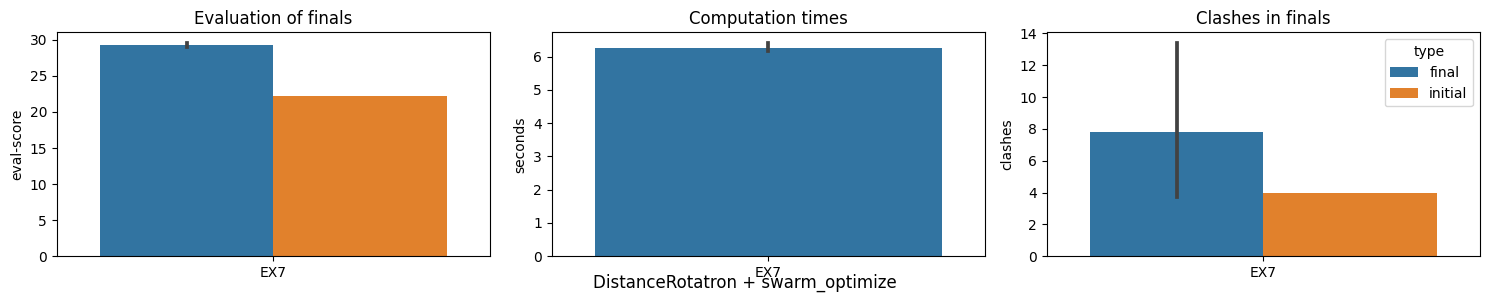

In [ ]:
_eval_history = auxiliary.transform_to_df(
    eval_history, initial_evals, "final", "initial"
)
_clash_history = auxiliary.transform_to_df(
    clash_history, initial_clashes, "final", "initial"
)
_time_history = auxiliary.transform_to_df(time_history)

if export_history:
    
    _eval_history.to_csv(f"{export_name_prefix}.eval_history.csv", index=False)
    _time_history.to_csv(f"{export_name_prefix}.time_history.csv", index=False)
    _clash_history.to_csv(f"{export_name_prefix}.clash_history.csv", index=False)

if visualize_eval_history or visualize_time_history or visualize_clashes:

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    if visualize_eval_history:
        _df = _eval_history.melt(id_vars="key", value_vars=["final", "initial"], var_name="type", value_name="eval")
        sns.barplot(data=_df, ax=axs[0], x="key", y="eval", hue="type")
        axs[0].set(title="Evaluation of finals", ylabel="eval-score", xlabel="")
        axs[0].legend().set_visible(False)
        
    if visualize_time_history:
        sns.barplot(data=_time_history, ax=axs[1], x="key", y=0)
        axs[1].set(title="Computation times", ylabel="seconds", xlabel="")

    if visualize_clashes:
        # _clash_history["diff"] = _clash_history["final"] - _clash_history["initial"]
        _df = _clash_history.melt(id_vars="key", value_vars=["final", "initial"], var_name="type", value_name="clashes")
        sns.barplot(data=_df, ax=axs[2], x="key", y="clashes", hue="type")
        axs[2].set(title="Clashes in finals", xlabel="")

    fig.tight_layout()

    fig.supxlabel(f"{rotatron_class.__name__} + {agent.__name__}")
    plt.savefig(f"{export_name_prefix}.plots.png")


Here can the 3d visualizations be viewed then 
---

In [ ]:
final_visuals["EX7"].show()

KeyError: 'EX7'

In [ ]:
if export_visualization and export_visualization:
    if not export_name_prefix:
        export_name_prefix = rotatron_class.__name__ + "." + agent.__name__
    for structure_id, v in final_visuals.items():
        if v:
            v.figure.write_html(f"{export_name_prefix}.{structure_id}.html")